In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Reding and Preprocessing images

we use cv2 libirary to read and resize images. The orginal images size are 1600 * 1200; so we should reduce image size because lack of memory.

Then just append images and masks to a numpy array and normalize them.

In [2]:
import cv2
from matplotlib import pyplot as plt

image_data = []
images_path = sorted(os.listdir('../input/fluorescent-neuronal-cells/all_images/images'))
for image_name in images_path:
        image = cv2.imread('../input/fluorescent-neuronal-cells/all_images/images/' + image_name, 0)
        image = cv2.resize(image, dsize=(768,512), interpolation=cv2.INTER_AREA)
        image_data.append(np.array(image))
        
        
mask_data = []
mask_path = sorted(os.listdir('../input/fluorescent-neuronal-cells/all_masks/masks'))
for mask_name in mask_path:
        mask = cv2.imread('../input/fluorescent-neuronal-cells/all_masks/masks/' + mask_name, 0)
        mask = cv2.resize(mask, dsize=(768,512), interpolation=cv2.INTER_AREA)
        mask_data.append(np.array(mask))
        
        
image_data = np.expand_dims(np.array(image_data),3) / 255
mask_data = np.expand_dims(np.array(mask_data),3) / 255

Let's see the shape of image and mask datas:

In [3]:
print(image_data.shape, mask_data.shape)

(283, 512, 768, 1) (283, 512, 768, 1)


Let's look at firs image and its mask image:

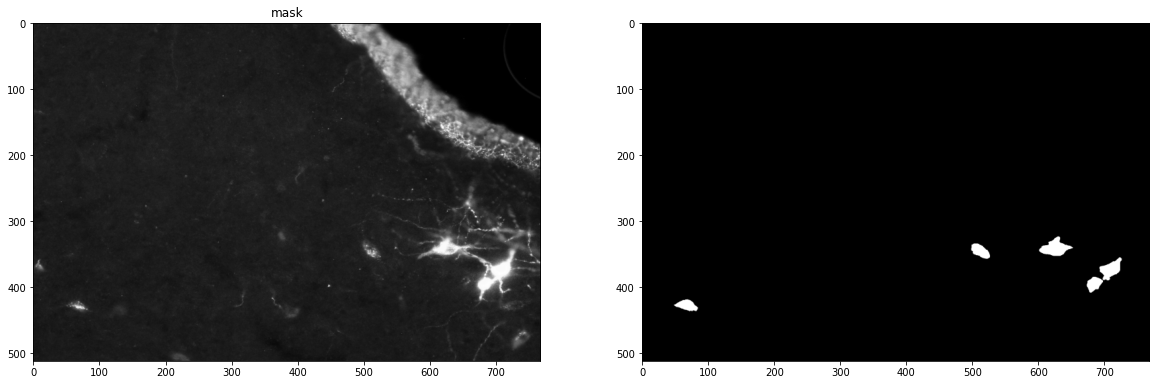

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(image_data[0], cmap='gray')
ax[0].set_title('image')
ax[1].imshow(mask_data[0], cmap='gray')
ax[0].set_title('mask')
fig.show()

# Training custom U-Net 

**building model**

This is a custom U-net neural network for semantic segmentation. I try to avoid overfeating by picking low values for number of CNV filters and number of hidden layers. In addition, we can use dropout layers too

In [5]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

#U-net model

s = Input((image_data.shape[1], image_data.shape[2], image_data.shape[3]))

#Contraction path
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.3)(c2)
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.4)(c3)
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

#Expansive path 
u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, c2])
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c4 = Dropout(0.4)(c4)
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

u5 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = concatenate([u5, c1], axis=3)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

model = Model(inputs=[s], outputs=[outputs])
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

2022-07-13 19:21:35.283373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 19:21:35.373434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 19:21:35.374205: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-13 19:21:35.376176: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 768, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 768, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 768, 8)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 768, 8)  584         dropout[0][0]                    
______________________________________________________________________________________________

**model u-net architecture**

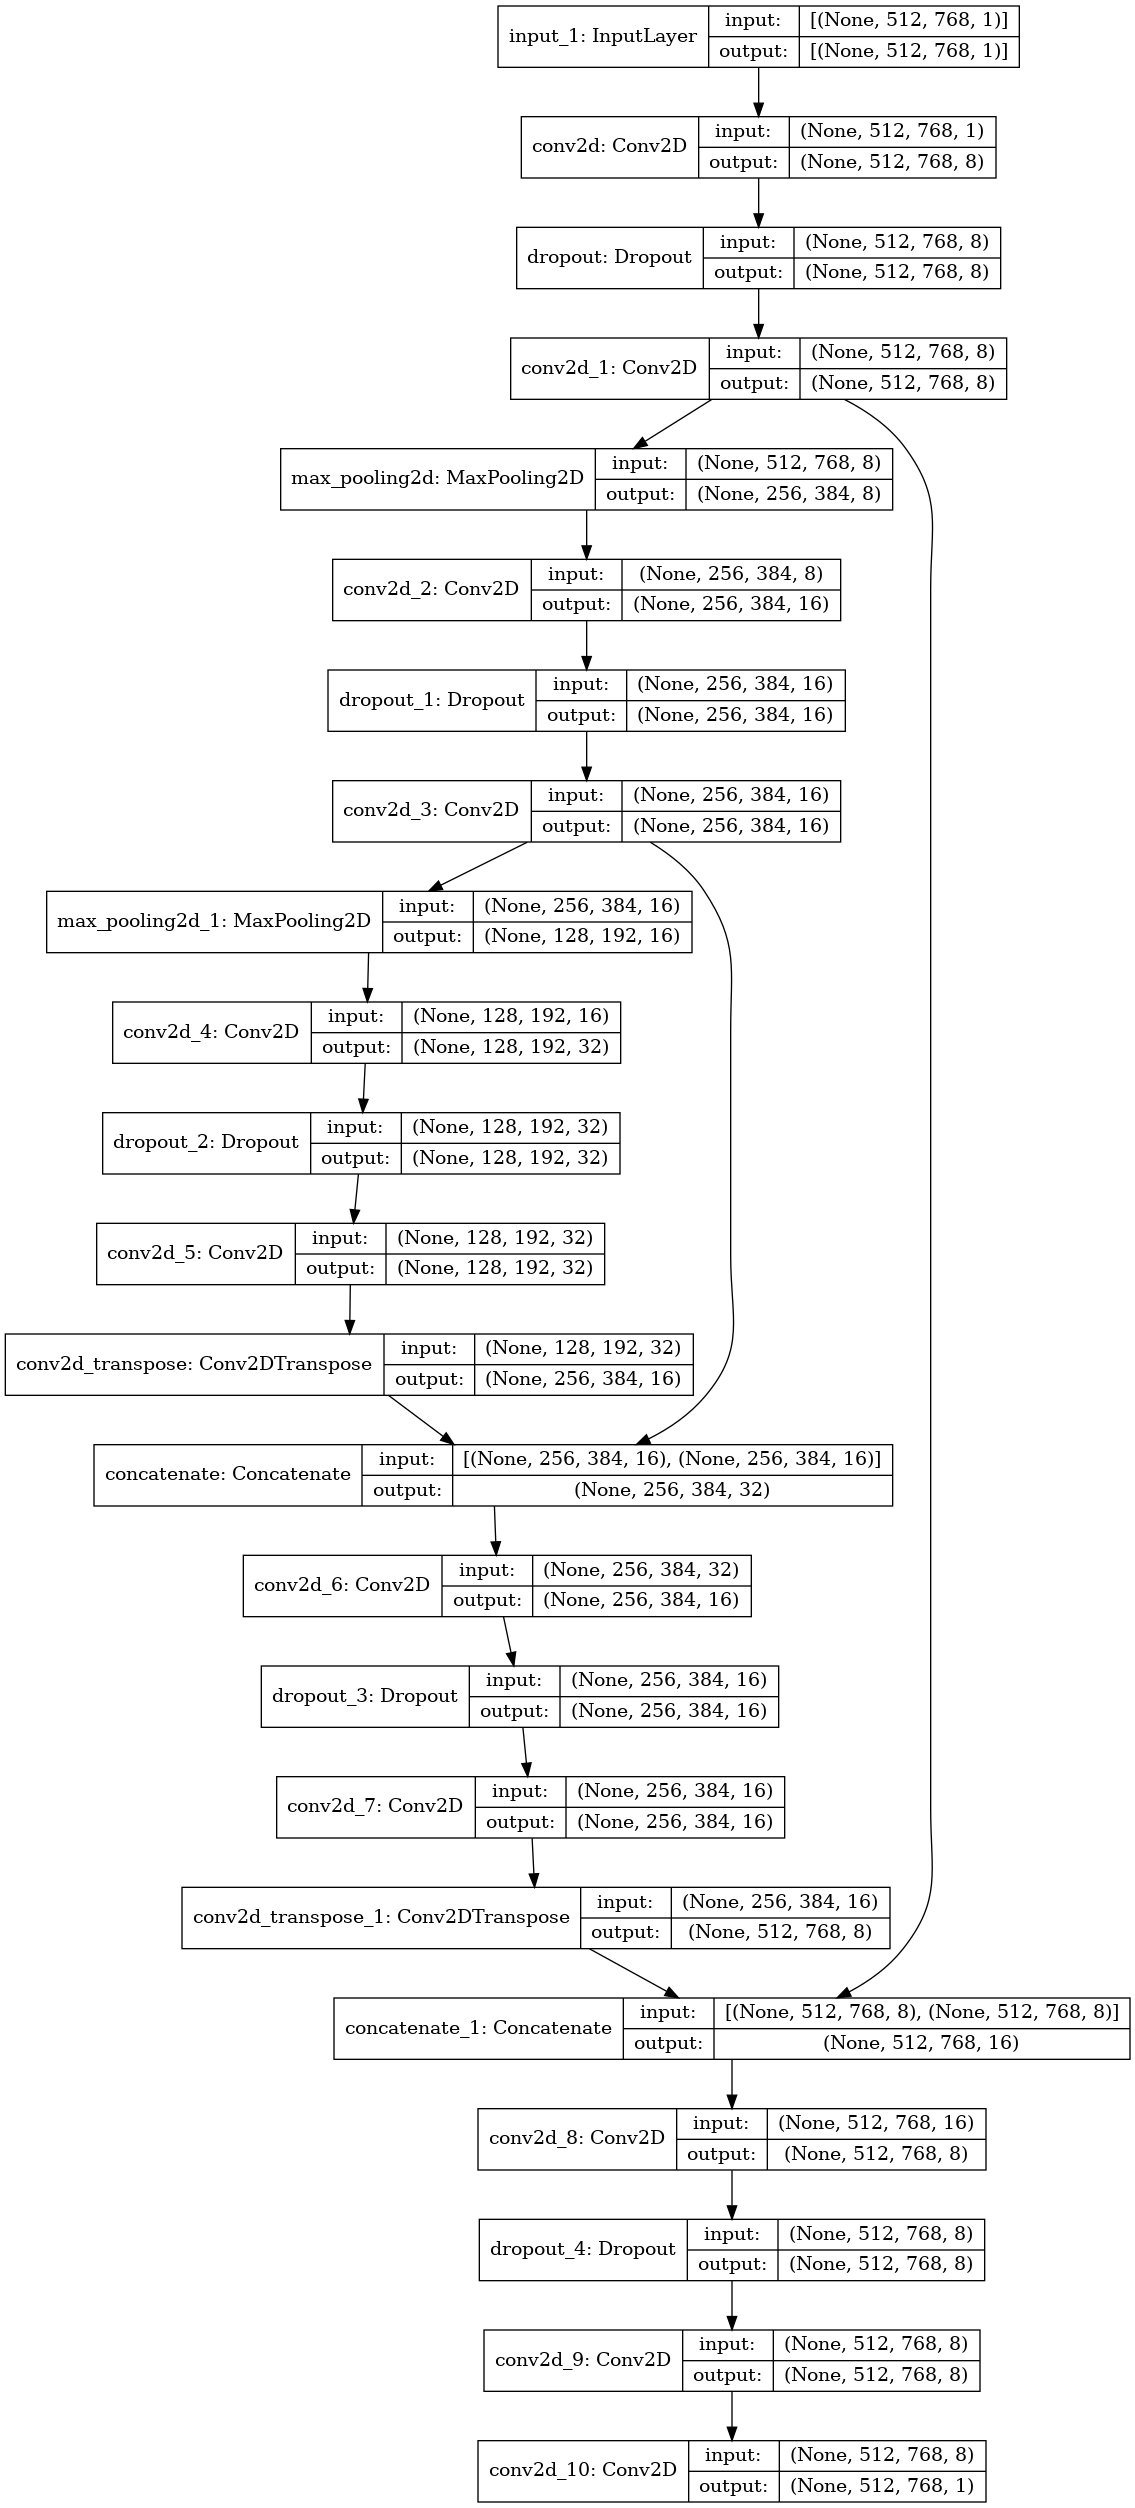

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True)

**Split data to train, validation and test sets**

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, mask_data, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('train data size:', X_train.shape[0], '\n')
print('validation data size:', X_val.shape[0], '\n')
print('test data size:', X_test.shape[0])

train data size: 228 

validation data size: 26 

test data size: 29


**Training model**

In [8]:
history = model.fit(x = X_train,
                    y = y_train,
                    batch_size = 30,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
                    validation_data = (X_val, y_val),
                    verbose = 1,
                    epochs = 30)

2022-07-13 19:21:42.958117: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-07-13 19:21:44.848118: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


8/8 [==============================] - 18s 903ms/step - loss: 0.6924 - accuracy: 0.7533 - val_loss: 0.6854 - val_accuracy: 0.9934
Epoch 2/30
8/8 [==============================] - 3s 395ms/step - loss: 0.6811 - accuracy: 0.9886 - val_loss: 0.6734 - val_accuracy: 0.9935
Epoch 3/30
8/8 [==============================] - 3s 396ms/step - loss: 0.6658 - accuracy: 0.9932 - val_loss: 0.6494 - val_accuracy: 0.9935
Epoch 4/30
8/8 [==============================] - 3s 391ms/step - loss: 0.6217 - accuracy: 0.9926 - val_loss: 0.5580 - val_accuracy: 0.9935
Epoch 5/30
8/8 [==============================] - 3s 395ms/step - loss: 0.3694 - accuracy: 0.9908 - val_loss: 0.1056 - val_accuracy: 0.9935
Epoch 6/30
8/8 [==============================] - 3s 386ms/step - loss: 0.1661 - accuracy: 0.9927 - val_loss: 0.0652 - val_accuracy: 0.9935
Epoch 7/30
8/8 [==============================] - 3s 386ms/step - loss: 0.0785 - accuracy: 0.9930 - val_loss: 0.0744 - val_accuracy: 0.9935
Epoch 8/30
8/8 [==============

Plotting results of the model icluding accuracy, validation accuracy, loss and validation loss

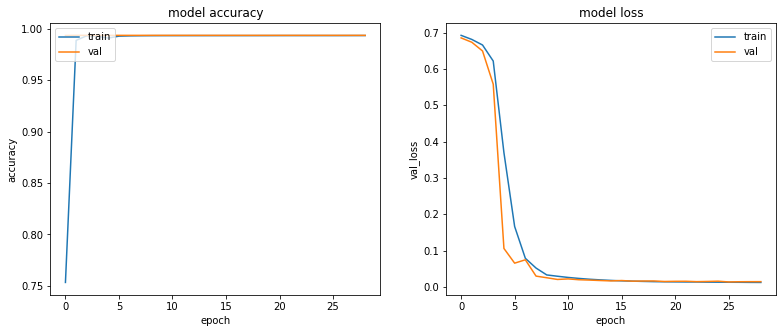

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

# Testing Model

just select a random image from test set and predict its mask!

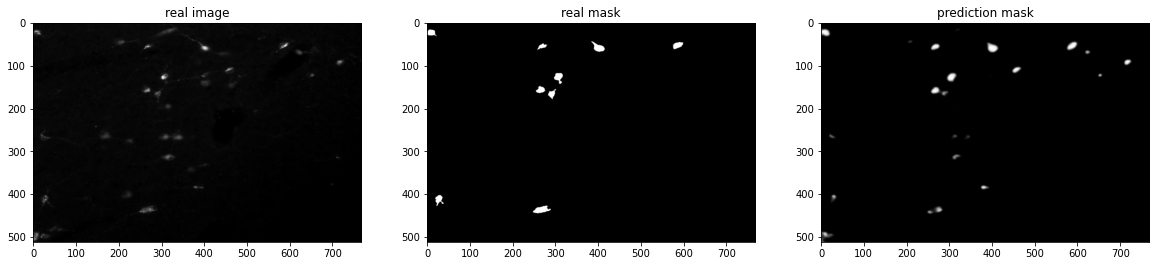

In [10]:
rndm_img = np.random.randint(0,len(X_test))

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(X_test[rndm_img], cmap='gray')
ax[0].set_title('real image')

ax[1].imshow(y_test[rndm_img], cmap='gray')
ax[1].set_title('real mask')

test_img = np.expand_dims(X_test[rndm_img], axis=0)
rslt = model.predict(test_img)[0]
ax[2].imshow(rslt, cmap='gray')
ax[2].set_title('prediction mask')

fig.show()